<a href="https://colab.research.google.com/github/Nguyen-The-Thanh/NguyenTheThanh_training_FMlab/blob/main/Ex/Ex17/Lab1_Graph_embedding_Problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Welcome to this lab!
At this lab, we will learn:
1. How to build a graph from a file or create a simple graph by ourself
2. Implement DeepWalk in the simplest way based on the paper [DeepWalk](https://arxiv.org/pdf/1403.6652.pdf). You can implement your own code or study some packages already made. I recommend reading Karateclub framwork, which is well-known for Unsupervised Learning on Graphs

# Exercise

## Download data and install packages

In [37]:
!gdown --id "1vqsjGzGZnpCEgHliEsVmAvzm9_1h3L-Y&export=download"
!unrar x -Y "/content/lab1.rar" -d "/content/"

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1vqsjGzGZnpCEgHliEsVmAvzm9_1h3L-Y&export=download
To: /content/lab1.rar
100% 50.0k/50.0k [00:00<00:00, 64.2MB/s]

UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/lab1.rar

Extracting  /content/lab1_big_edgelist.txt                                99%  OK 
Extracting  /content/lab1_small_edgelist.txt                             100%  OK 
All OK


## Build a graph

In [38]:
import networkx as nx
import numpy as np
import torch

### TO DO: Create graphs

Create a graph from the file: "lab1_small_edgelist.txt"

In [39]:
# TO DO: Create a graph from the file: "lab1_small_edgelist.txt"

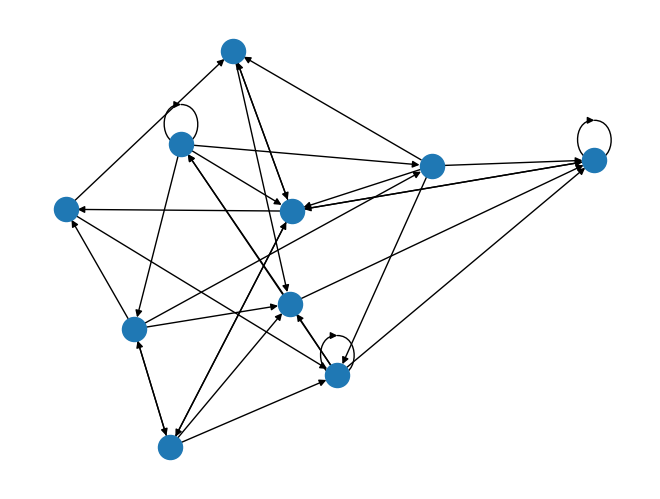

In [40]:
G1 = nx.read_edgelist('lab1_small_edgelist.txt',create_using=nx.DiGraph(),nodetype=None,data=[('weight',int)])
nx.draw(G1)

Create a graph by generating nodes and edges.

In [41]:
# TO DO: Create a graph by generating nodes and edges.

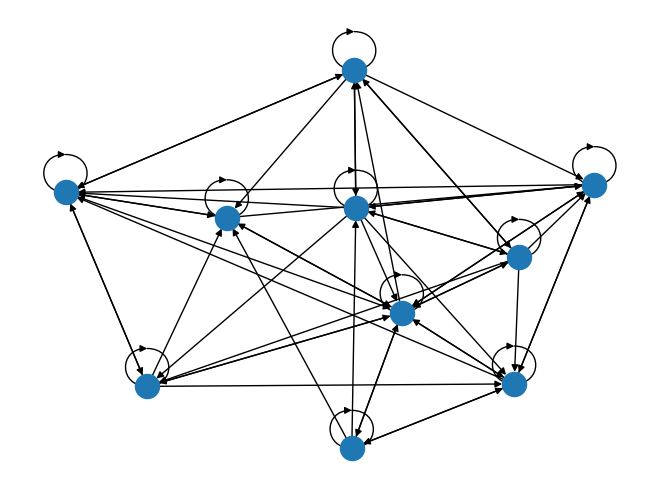

In [42]:
A_torch = torch.randint(0, 2, (10, 10))
A_np = np.random.randint(2, size=(15, 15))

def build_graph(adj_matrix):
    graph = nx.DiGraph()  # note nx.Graph() v.s. nx.DiGraph()
    for i in range(len(adj_matrix)):
        for j in range(len(adj_matrix[i])):
            if adj_matrix[i][j] == 1:
                graph.add_edge(i, j)
            if i == j:
                graph.add_edge(i, j)
    return graph

G2 = build_graph(A_torch)
nx.draw(G2)

## Implement DeepWalk

### Packages: Import necessary packages

In [43]:
import networkx as nx
from joblib import Parallel, delayed
import random
import itertools
import numpy as np
!pip install gensim
from gensim.models import Word2Vec

### Utils: Processing data

In [44]:
def partition_num(num, workers):
    if num % workers == 0:
        return [num//workers]*workers
    else:
        return [num//workers]*workers + [num % workers]

### TO DO: Implement DeepWalk

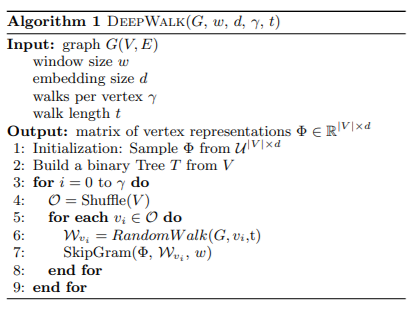

In [45]:
# Please implement your code here.
# 1. Try to build your own code
# 2. Try to use class RandomWalk built in the KarateClub framework (used in homework's solution)
class RandomWalker:
  def __init__(self, G, num_walks, walk_length):
      """
      :param G: Graph
      :param num_walks: a number of walks per vertex
      :param walk_length: Length of a walk. Each walk is considered as a sentence
      """
      self.G = G
      self.num_walks = num_walks
      self.walk_length = walk_length


  def deepwalk_walk(self, start_node):
      """
      :param start_node: Starting node of a walk
      """
      walk = [start_node]
      while len(walk) < self.walk_length:
          cur = walk[-1]
          # Check if having any neighbors at the current node
          cur_nbrs = list(self.G.neighbors(cur))
          if len(cur_nbrs) > 0:
              # Random walk with the probability of 1/d(v^t). d(v^t) is the node degree
              walk.append(random.choice(cur_nbrs))
          else:
              break
      return walk


  def simulate_walks(self, workers=1, verbose=0):
      """
      :param workers: a number of workers running in parallel processing
      :param verbose: progress bar
      """
      G = self.G
      nodes = list(G.nodes())
      results = Parallel(n_jobs=workers, verbose=verbose)(
          delayed(self._simulate_walks)(nodes) for num in
          partition_num(self.num_walks, workers))
      walks = list(itertools.chain(*results))
      return walks

  # INFORMATION EXTRACTOR
  def _simulate_walks(self, nodes):
      walks = []
      # Iterate all walks per vertex
      for _ in range(self.num_walks):
          random.shuffle(nodes)
          # Iterate all nodes in a walk
          for v in nodes:
            walks.append(self.deepwalk_walk(start_node=v))
      return walks

In [48]:
class DeepWalk:
    def __init__(self, graph, walk_length, num_walks, workers=1):

        self.graph = graph
        self.w2v_model = None
        self._embeddings = {}

        self.walker = RandomWalker(graph, num_walks=num_walks, walk_length=walk_length)
        self.sentences = self.walker.simulate_walks(workers=workers, verbose=1)

    def train(self, embed_size=128, window_size=5, workers=1, iter=5, **kwargs):

        kwargs["sentences"] = self.sentences
        kwargs["min_count"] = kwargs.get("min_count", 0)
        kwargs["vector_size"] = embed_size # Changed 'size' to 'vector_size'
        kwargs["sg"] = 1  # skip gram
        kwargs["hs"] = 1  # deepwalk use Hierarchical Softmax
        kwargs["workers"] = workers
        kwargs["window"] = window_size
        kwargs["epochs"] = iter # Changed 'iter' to 'epochs' for newer gensim versions

        print("Learning embedding vectors...")
        model = Word2Vec(**kwargs) # Pay attention here
        print("Learning embedding vectors done!")

        self.w2v_model = model
        return model

    def get_embeddings(self,):
        if self.w2v_model is None:
            print("model not train")
            return {}

        self._embeddings = {}
        for word in self.graph.nodes():
            self._embeddings[word] = self.w2v_model.wv[word]

        return self._embeddings

### Run graph embedding

In [49]:
G = nx.read_edgelist('lab1_big_edgelist.txt',create_using=nx.DiGraph(),nodetype=None,data=[('weight',int)])# Read graph
model = DeepWalk(G,walk_length=10,num_walks=80,workers=1)#init model
model.train(window_size=5,iter=3)# train model
embeddings = model.get_embeddings()# get embedding vectors

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s finished


Learning embedding vectors...


Learning embedding vectors done!


In [50]:
count = 0
for i, (k, v) in enumerate(embeddings.items()):
  print("Index {} has key {} and value {}".format(str(i), k, v))
  count += 1
  if count == 2:
    break

Index 0 has key 1397 and value [ 0.42218918  0.06821395 -0.20970206 -0.3659649   0.36929616  0.43710664
  0.29029962 -0.59920835  0.39794457  0.06575723  0.08570643 -0.00783459
 -0.3349647  -0.19366142  0.7824252   0.01509864 -0.18021916  0.6822323
 -0.10130893 -0.2361496  -0.12530501 -0.2995423  -0.3701727   0.06964999
  0.31871244 -0.16411482 -0.11559896 -0.21444038  0.45547453  0.25603348
 -0.00727605 -0.6779236  -0.16177313  0.4030199  -0.02804628 -0.04690578
 -0.8618334  -0.47482714  0.46435738 -0.5571213  -0.45313436  0.4405362
 -0.22498962 -0.12253681 -0.02349523  0.07027662 -0.15452082  0.7897368
 -0.03895769  0.1735698   0.6884773  -0.02245864  0.04643375  0.05598231
 -0.06511032  0.14745654 -0.38359576 -0.22124869 -0.43615475 -0.23901998
 -0.60624516  0.4660159   0.23914942 -0.04788224 -0.3521071  -0.06218551
  0.31921512 -0.07214329  0.09380419 -0.09228117 -0.3737786   0.4042468
 -0.19108377 -0.06761655  0.02875179 -0.240174   -0.23838454  0.19222535
 -0.14694104 -0.07040279

# Questions

Did you see that we use the function "Word2vec" as the primary function to implement the DeepWalk algorithm?

The reason is that DeepWalk is based on the idea of Word2vec. As a result, all we need is packed in the implementation of Word2vec. Within a short amount of time, we couldn't go through all the code.

This is your homework. The details will be shown in the file "Lab3 - Homeworks".

Please take a look at [this file](https://github.com/RaRe-Technologies/gensim/blob/develop/gensim/models/word2vec.py) for more details.